# 数据下载


## ERA5

- 程序来源：[Initializing the WRF model with ERA5 (pressure level)](https://dreambooker.site/2019/10/03/Initializing-the-WRF-model-with-ERA5-pressure-level/)
- 程序作用：从ECMWF官网下载WRF运行所需的ERA5数据。
- 使用方法：
   1. 生成`.cdsapirc`文件。执行命令
      ```bash
      echo 'url: https://cds.climate.copernicus.eu/api/v2
      key: 49717:348c95ab-4e23-4d3e-9344-f0ebdcfb6091' > ~/.cdsapirc
      ```
   2. 安装cdsapi库。在python环境中执行命令
      ```bash
      pip install cdsapi
      ```
   3. 运行以下程序，下载所需文件到`os.chdir`指定的目录下。详见[官方说明](https://cds.climate.copernicus.eu/api-how-to)。

In [9]:
from trans import tomorrow
from os.path import join
from glob import glob
import numpy as np
import cdsapi
import os
os.chdir("/home/sakura/Lys/sar/data/era5/")


def download(time, area):
    """

    :param time: 形如YYYYMMDDHHMM的时间，整型。注意带上了分钟，不带也能跑，但分钟在WRF运算时有用。
    :param area: 形如[north, west, south, east]的范围，整型列表。
    :return: None
    """
    year, month, day, hour = time[:4], time[4:6], time[6:8], time[8:10]
    c = cdsapi.Client()
    content = {'single': {
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            '2m_temperature', 'land_sea_mask', 'mean_sea_level_pressure',
            'sea_ice_cover', 'sea_surface_temperature', 'skin_temperature',
            'snow_depth', 'soil_temperature_level_1', 'soil_temperature_level_2',
            'soil_temperature_level_3', 'soil_temperature_level_4', 'surface_pressure',
            'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2',
            'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4',
        ], },
        'pressure': {
        'pressure_level': [
            '1', '2', '3', '5', '7', '10', '20', '30', '50', '70', '100', '125', '150',
            '175', '200', '225', '250', '300', '350', '400', '450', '500', '550', '600',
            '650', '700', '750', '775', '800', '825', '850', '875', '900', '925', '950',
            '975', '1000'],
        'variable': [
            'geopotential', 'relative_humidity', 'specific_humidity',
            'temperature', 'u_component_of_wind', 'v_component_of_wind']}}
    for k, v in content.items():
        v['product_type'] = 'reanalysis'
        v['area'] = area
        v['format'] = 'grib'
        if hour == "23":
            this_day = time[:8]
            next_day = tomorrow(this_day)
            v['date'] = '%s/%s' % (this_day, next_day),
            v['time'] = ['00:00', '23:00']
        else:
            v['year'] = year
            v['month'] = month
            v['day'] = day
            v['time'] = ['%s:00' % hour, '%02d:00' % (int(hour)+1)]
        c.retrieve('reanalysis-era5-%s-levels' %
                   k, v, '%s-%s.grib' % (time, k))


def get_time(dir):
    """
    从所有影像数据的.par头文件中提取成像时间，以针对性地从.grib文件中提取对应的气象数据

    :param dir: 影像所在的路径。头文件的完整路径为"dir/*/*.par"
    :return: [YYYYMMDDHHMM], type=int
    """
    time = []  # 提取结果，是一个n×5的字符串矩阵，列依次是年、月、日、时、分
    for i in glob(join(dir, "*/*.par")):  # 遍历每一个*.par文件
        with open(i) as f:
            for j in f.readlines():
                if j[:5] == "date:":  # 匹配行，获取年、月、日
                    year, month, day = j.split()[1:4]
                    time.append("%04d%02d%02d" %
                                (int(year), int(month), int(day)))
                elif j[:11] == "start_time:":  # 匹配成像时刻
                    minute = float(j.split()[1])
                    hour = np.floor(minute / 3600)
                    minute = np.floor((minute - hour * 3600) / 60)
                    # 获取小时和分钟
                    time[-1] = "%s%02d%02d" % (time[-1], hour, minute)
    # 使用集合来除去重复时刻，返回n维数组，每一项是形如"YYYYMMDDHHMM"的整型
    return map(str, sorted(map(int, set(time))))


if __name__ == "__main__":
    from multiprocessing import Pool, cpu_count
    p = Pool(cpu_count())
    for time in get_time("../images/"):
        p.apply_async(download, args=(time, [42, 115, 39, 118]))
    p.close()
    p.join()

可以通过以下代码来验证，下载的数据是否又好又全。

In [7]:
import cfgrib
from glob import glob
from os.path import basename
from trans import next_hour


def dt642str(dt64):
    s = str(dt64)
    return s[:4] + s[5:7] + s[8:10] + s[11:13]


if __name__ == "__main__":
    for i in glob("/home/sakura/Lys/sar/data/era5/*.grib"):
        amount, is_single = 0, True
        for j in cfgrib.open_datasets(i):
            if amount == 0:
                if "isobaricInhPa" in j.dims:
                    is_single = False
                content = list(map(dt642str, j['time'].values))
                time = basename(i)[:10]
                assert (time in content) and (next_hour(time) in content)
            amount += len(j)
        if is_single:
            assert amount == 19
        else:
            assert amount == 6
    for i in glob("/home/sakura/Lys/sar/data/era5/*.idx"):
        os.remove(i)

## NCEP

In [15]:
# NCEP数据其实没在本实验中用上，所以只是写在这里备用
# 需要先登录RDA网站，https://rda.ucar.edu/
# 账户：1700012467@pku.edu.cn
# 密码：426sarlab
from datetime import datetime, timedelta
from trans import next_hour
import os
os.chdir("/home/sakura/Lys/sar/data/")


def get_urls(time):
    interval = 6
    time = time[:8] + "%02d" % (int(time[8:10]) // interval * interval)
    next_time = time
    for i in range(interval):
        next_time = next_hour(next_time)
    return "".join(map(lambda t: 'https://rda.ucar.edu/data/OS/ds083.2/grib2/%s/%s.%s/fnl_%s%s%s_%s_00.grib2\n' % (t[:4], t[:4], t[4:6], t[:4], t[4:6], t[6:8], t[8:10]), (time, next_time)))


if __name__ == "__main__":
    res = ''
    for time in get_time("./images/"):
        res = res + get_urls(time)
    with open('ncep_files.txt', 'w')as f:
        f.write(res)
    # 所有下载链接都写在`ncep_files.txt`中了，可以使用多线程下载软件下载。

## VMF1

对流层延迟模型分为两类：离散模型和经验模型。

- 离散模型一般具有固定的时间分辨率，如每天有0时、6时、12时、18时4个时刻的数据。需要进行插值得到目标时间的数据。
- 经验模型是长期的平均，给定时间和地点，可以计算出所有参数。

VMF1模型是一种离散模型。

## IGS延迟产品

获取下载地址

In [15]:
from datetime import datetime
from glob import glob
from os.path import basename


class BJNM(object):
    def doy(yy: int, mm: int, dd: int) -> int:
        def i2s(y, m, d):
            return datetime.strptime("%02d%02d%02d" % (y, m, d), "%y%m%d")
        return (i2s(yy, mm, dd) - i2s(yy, 1, 1)).days + 1

    def __init__(self, yy: int, mm: int, dd: int) -> None:
        doy = BJNM.doy(yy, mm, dd)
        self.__url = "https://cddis.nasa.gov/archive/gnss/products/troposphere/zpd/%04d/%03d/bjnm%03d0.%02dzpd.gz\n" % (
            2000+yy, doy, doy, yy)

    def get(self) -> str:
        return self.__url


def download_delays():
    f = open("./download_delays.txt", "w")
    for i in glob("../data/wrf/wrfout_*"):
        j = tuple(map(lambda x: int(x[-2:]),
                  basename(i).split("_")[2].split("-")))
        b = BJNM(j[0], j[1], j[2]).get()
        f.write(b)
    f.close()


# download_delays()


与ECMWF数据比较

In [1]:
from read import read_wrf
from glob import glob
from atmosphere import atmos2N, Nh2L
from trans import ecs2wgs


def compare_igs(wrf_name: str, igs_name: str):
    a, h, grid = read_wrf(
        glob("/home/sakura/Lys/sar/data/wrfinput/%s*" % wrf_name)[0])
    N_dry, N_wet, offset = atmos2N(a)
    delay = Nh2L(N_dry + N_wet, h) + offset

    if igs_name[:4] == "bjnm":
        pos = ecs2wgs(-2154287.579, 4373440.017,  4098885.652)
    elif igs_name[:4] == "bjfs":
        pos = ecs2wgs(-2148744.356,  4426641.220,  4044655.865)
    else:
        raise ValueError("站点无法识别: %s" % igs_name[:4])
    with open(glob("/home/sakura/Lys/sar/data/%s" % igs_name)[0], 'r')as f:
        delays = list(
            map(lambda x: float(x.split()[2]) / 1e3, f.readlines()[61:349]))

        i = t2sod(int(t[:2]), int(t[2:4]), int(t[4:6])) / 300
        last = int(i)
        rate = i - last
        return delays[last]*(1-rate)+delays[last+1]*rate


SyntaxError: invalid syntax (3325775112.py, line 18)

# WRF处理

生成一个脚本，将原始数据交给WRF处理。

In [6]:
# 参考：http://bbs.06climate.com/forum.php?mod=viewthread&tid=30962
from glob import glob
from functools import partial
from trans import next_hour
import numpy as np
from os import chdir, cpu_count
chdir("/home/sakura/Lys/sar/data/")


def update_sh(file, key, value):
    """
    输出一行bash命令，用于更新.sh文件某一行的值

    :param file: 待更新的文件，一般是namelist.wps或namelist.input
    :param key: 用于索引行的键
    :param value: 更新结束后，键对应的值
    :return: 待执行的bash命令
    """
    return """
sed -i "s| %s .*$| %s = %s,|" ./%s""" % (key, key, value, file)


def ll2xy(d):
    """
    wrf使用lat-lon坐标系时，dx和dy是经纬度大小，但后续运行wrf.exe时需要转换为距离大小。wrf内部有个WRF_EARTH_RADIUS=6370km的常数项，以此将经纬度长度转换为距离长度。

    :param d: 需转换的值，dx或dy，是经纬度表示的。
    :return: 转换后的值，单位是米。
    """
    return d * 6370 * np.pi / 180 * 1000


def get_sh(time, ref_lon, ref_lat, e_we, e_sn, dx, dy, geog_data_path="/home/wrf/DATA/WPS_GEOG/"):
    """
    主程序，用于生成脚本，通过脚本来运行wrf软件。

    :param time: 形如YYYYMMDDHHMM的字符串，是SAR影像的成像时刻。
    :param ref_lon: 目标区域的中心经度
    :param ref_lat: 目标区域的中心纬度
    :param e_we: 目标区域东西方向上的网格数+1（100表示99个网格）
    :param e_sn: 目标区域南北方向上的网格数+1
    :param dx: 目标区域东西方向上的分辨率（经度表示）
    :param dy: 目标区域南北方向上的分辨率（纬度表示）
    :param geog_data_path: 静态数据（DEM、地表反射率等）的存放路径
    :return: None
    """
    year, month, day, hour, minute = time[:4], time[4:6], time[
        6:8], time[8:10], time[10:12]
    end = next_hour(time[:10])
    year2, month2, day2, hour2 = end[:4], end[4:6], end[6:8], end[8:]
    output = "cd /home/wrf/WPS/"  # output将包含所有bash命令

    line = partial(update_sh, "namelist.wps")  # line函数对namelist.wps逐行更新

    output += line("max_dom", "1")
    output += line("start_date", "'%s-%s-%s_%s:00:00'" %
                   (year, month, day, hour))
    output += line("end_date", "'%s-%s-%s_%s:00:00'" %
                   (year2, month2, day2, hour2))
    output += line("interval_seconds", "3600")
    output += line("prefix", "'PL'")
    output += """
ln -sf ./ungrib/Variable_Tables/Vtable.ECMWF Vtable  # 包含了sl和pl的查找表
ln -sf ../DATA/era5/%s-pressure.grib GRIBFILE.AAA
./ungrib.exe""" % time
    output += line("prefix", "'SL'")
    output += """
ln -sf ../DATA/era5/%s-single.grib GRIBFILE.AAA
./ungrib.exe""" % time
    # 以上是ungrib的内容
    output += line("parent_id", "1")
    output += line("parent_grid_ratio", "1")
    output += line("i_parent_start", "1")
    output += line("j_parent_start", "1")
    output += line("e_we", e_we)
    output += line("e_sn", e_sn)
    output += line("geog_data_res", "'default'")
    output += line("dx", dx)
    output += line("dy", dy)
    output += line("map_proj", "'lat-lon'")
    output += line("ref_lat", ref_lat)
    output += line("ref_lon", ref_lon)
    output += line("truelat1", ref_lat)
    output += line("truelat2", ref_lat)
    output += line("stand_lon", ref_lon)
    output += line("geog_data_path", "'%s'" % geog_data_path)
    output += """
./geogrid.exe"""
    # 以上是geogrid的内容
    output += line("fg_name", "'PL', 'SL'")
    output += """
./metgrid.exe"""
    # 以上是metgrid的内容

    line = partial(update_sh, "namelist.input")  # line函数对namelist.input逐行更新

    output += """
cd ../WRF/test/em_real
ln -sf ../../../WPS/met_em.d01.* ."""
    output += line("run_days", "0")
    output += line("run_hours", "0")
    output += line("run_minutes", str(int(minute) + 1))
    output += line("run_seconds", "0")
    output += line("start_year", year)
    output += line("start_month", month)
    output += line("start_day", day)
    output += line("start_hour", hour)
    output += line("end_year", year2)
    output += line("end_month", month2)
    output += line("end_day", day2)
    output += line("end_hour", hour2)
    output += line("interval_seconds", "3600")
    output += line("input_from_file", ".true.")
    output += line("history_interval", "1")
    output += line("frames_per_outfile", "1")
    output += line("restart", ".false.")
    output += line("restart_interval", "60")
    dx2 = ll2xy(float(dx))
    output += line("time_step", str(int(6 * dx2 / 1000)))
    output += line("max_dom", "1")
    output += line("e_we", e_we)
    output += line("e_sn", e_sn)
    output += line("e_vert", "45")
    output += line("num_metgrid_levels", "38")
    output += line("dx", "%.3f" % dx2)
    output += line("dy", "%.3f" % ll2xy(float(dy)))
    n = cpu_count()
    output += """
mpirun -np %d ./real.exe
mpirun -np %d ./wrf.exe
mv wrfout_d01_%s-%s-%s_%s:%s:00 /home/wrf/DATA/wrf/
rm wrfout_d01_*""" % (n, n, year, month, day, hour, minute)
    with open("%s.sh" % time, "w")as f:
        f.write(output)


if __name__ == "__main__":
    ref_lon = "116.28"
    ref_lat = "40.22"
    e_we = "100"  # 长度
    e_sn = "100"
    dx = "0.009"
    dy = "0.009"
    for i in get_time("../images/"):  # 遍历.par文件，得到所有时间，生成对应的bash脚本
        get_sh(str(i), ref_lon, ref_lat, e_we, e_sn, dx, dy)
    with open("start.sh", "w")as f:  # 将所有bash脚本合并为start.sh
        for i in glob("2*.sh"):
            f.write("./%s\n" % i)
    # 只需执行start.sh即可生成所有影像延迟校正的WRF数据


# 数据介绍

## ERA5

ERA5数据参数如下

|数据类型|网格数据|
|-|-|
|投影类型|常规经纬度网格|
|水平覆盖范围|全球|
|水平分辨率|0.25◦ × 0.25◦|
|垂直覆盖范围|1000hPa~1hPa|
|垂直分辨率|37 个气压层|
|时间分辨率|小时|
|数据格式|GRIB|

## WRF

WRF处理结果中与延迟有关的参数

|参数名|单位|介绍|
|-|-|-|
|PB|$Pa$|基准气压（Base Pressure）|
|P|$Pa$|扰动气压（Perturbation Pressure）|
|T|$K$|位温扰动（Potential Temperature Perturbation），即实际温度与基准温度（$300K$）的差值|
|QVAPOR|$kg/kg$|水蒸气混合比|
|PHB|$m^{2}s^{-2}$|基准位势高（Base Geopotential Height）|
|PH|$m^{2}s^{-2}$|位势高扰动（Perturbation of the Geopotential Hieght）|

转换公式如下，其中press为气压（$hPa$），ta为气温（$K$），hur为比湿（Specific Humidity）（$g/g$）：

$$press=\frac{P+PB}{100}$$

$$ta=(T+300)(\frac{press}{p0})^{\frac{R}{C_p}}$$

$$hur=\frac{QVAPOR}{QVAPOR+1}$$


式中$p0$为标准气压（$1000hPa$），$R$为气体常数，$C_p$为定压比热，计算公式如下


$$\frac{R}{C_p}=\frac{R_d(1+0.61hur)}{C_{pd}(1+0.85hur)}=\frac{287(1+0.61hur)}{1004(1+0.85hur)}$$


若$hur<4\times10^{-2}g/g$，可近似取$\frac{R}{C_p}\approx0.286$。另外，在计算折射指数时一般不使用比湿，而是使用水汽分压$e_w$

$$e_w=press\times\frac{QVAPOR}{QVAPOR+0.622}$$

对于高程$z$，每层边界的高程$z_{staggered}$（单位：$m$）为

$$z_{staggered}=\frac{PH+PHB}{9.81}$$

注意$z_{staggered}[0]$是地表高程，即文件中的HGT变量。显然，$z_{staggered}$的层数比其他参数多1，可通过相减得出每层高度；如果要取一个高度代表该层，一般取平均数

$$z(k)=\frac{z_{staggered}(k)+z_{staggered}(k+1)}{2}$$

总之，这样就得到了每个高程$z$对应的气压press，气温ta，水汽分压$e_w$，还有每层的边界高程。值得注意的是，为了节省空间，WRF运行结果是float32类型，在运算时要将数据类型转换为float64，否则后续计算会严重失真。

# 对流层校正

## 基本原理

对流层对SAR信号的影响可以用折射指数$n$来表示，$n$的取值一般为$1.00026\sim1.00046$。有时用无线电折射率(Radio Refractivity Index)$N$来表示，显然N的取值一般为$260\sim460$。

$$N=(n-1)\times10^6$$

根据引起折射的气体成分，可以将$N$表达为

$$N=N_{dry}+N_{wet}$$

$$N_{dry}=k_1\frac{press-e_w}{ta}$$

$$N_{wet}=k_2\frac{e_w}{ta}+k_3\frac{e_w}{ta^2}$$

式中$k_1=77.6K/hPa, k_2=71.6K/hPa, k_3=3.75\times10^5K^2/hPa$。得到了$N$之后，可以通过下式计算对流程天顶延迟$\Delta L$

$$\Delta L=10^{-6}\int_{z_0}^\infty Ndz$$

如若将延迟分解为静力学延迟和湿延迟，则

$$\Delta L=10^{-6}\frac{k_1R_dP_0}{g_0}+10^{-6}\int_{z_0}^\infty(k_2'\frac{e_w}{ta}+k_3\frac{e_w}{ta^2})dz$$

式中$R_d=287.05J/(kg\cdot K)$是干气体常数，$P_0$是地表气压，$g_0$是重力加速度，$k_2'=k_2-k_1\frac{R_d}{R_w}=23.3(K/hPa)$，$R_w=461.495J/(kg\cdot K)$是水汽的气体常数。

第一项静力学延迟的典型值为$2.3m$，第二项湿延迟的典型值为$0.4m$，其中湿延迟的变化幅度较大。可以验证一下$N$值是否符合预期

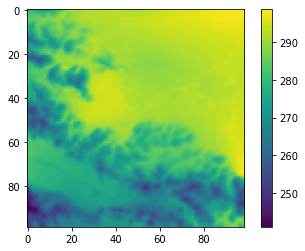

In [2]:
import matplotlib.pyplot as plt
from read import read_wrf
from atmosphere import atmos2N

path = '/home/sakura/Lys/sar/data/wrf/wrfout_d01_2013-05-12_22:17:00'
a, h, grid = read_wrf(path)
N_dry, N_wet = atmos2N(a)
N = N_dry + N_wet
plt.imshow(N[0])
plt.colorbar()
plt.show()

## WRF存在的问题

WRF运行结果中，最高层的气压约为$50hPa$，而非$0$，使得延迟估计值比实际值小约$10cm$，需要修正。

静力学延迟和湿延迟计算方法只借助了地表气压，所以计算值与实际值是没有系统误差的。如果通过该方法计算天顶向延迟，结果和gacos非常接近。这里借用一下修改后的`test_atmosphere.py`文件中的`compare_with_gacos`函数：

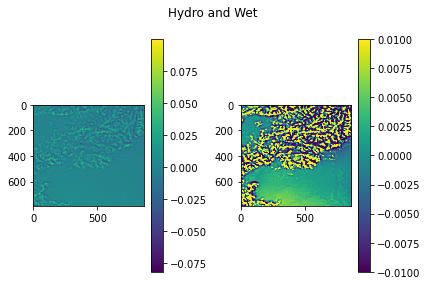

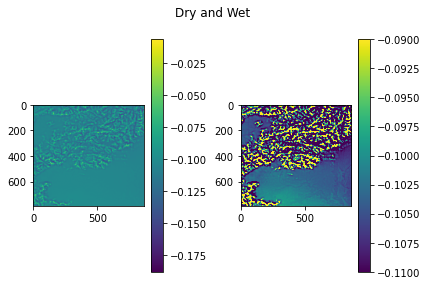

In [2]:
from tifffile import TiffFile
from functools import partial
from read import read_wrf, lon2index, lat2index
from atmosphere import Nh2L, get_hydro_wet_L, atmos2N
import matplotlib.pyplot as plt
import numpy as np


def compare_with_gacos(delay, grid):
    lon_f = partial(lon2index, grid, check=False)
    lat_f = partial(lat2index, grid, check=False)
    lons = [grid.lon + grid.dx / 2, 0]
    lons[1] = lons[0] + (grid.cols - 1) * grid.dx
    lats = [grid.lat + grid.dy / 2, 0]
    lats[1] = lats[0] + (grid.rows - 1) * grid.dy
    with TiffFile("/home/sakura/Lys/sar/data/20130512.ztd.tif")as img:
        _, _, _, left, top, _ = img.pages[0].tags.get('ModelTiepointTag').value
        dx, dy, _ = img.pages[0].tags.get('ModelPixelScaleTag').value
        # gacos分辨率约90m，远高于wrf结果
        top, left = top - dy / 2, left + dx / 2  # 北纬40-41度，东经116-117度
        gacos = img.pages[0].asarray()

        def ix2lx(i): return left + i * dx
        def iy2ly(i): return top - i * dy
        def lx2ix(l): return int((l - left) / dx)
        def ly2iy(l): return int((top - l) / dy)

        bottom, right = iy2ly(gacos.shape[0]-1), ix2lx(gacos.shape[1]-1)
        lon_start = max(lons[0], left)
        lon_end = min(lons[1], right)
        lat_start = max(lats[0], bottom)
        lat_end = min(lats[1], top)
        sx = lx2ix(lon_start)
        ex = lx2ix(lon_end)
        sy = ly2iy(lat_end)
        ey = ly2iy(lat_start)

        xs = np.array(range(sx, ex+1))
        ys = np.array(range(sy, ey+1))

        x, y = np.meshgrid(xs, ys)
        gacos = gacos[y, x]
        xs = np.int64(lon_f(ix2lx(xs)))
        ys = np.int64(lat_f(iy2ly(ys)))
        x, y = np.meshgrid(xs, ys)

        delay = delay[y, x]
        return delay - gacos


def main():
    path = '/home/sakura/Lys/sar/data/wrf/wrfout_d01_2013-05-12_22:17:00'
    a, h, grid = read_wrf(path)
    N_dry, N_wet, offset = atmos2N(a)
    # atmos2N函数给出了补偿值，但我们暂时忽略
    L_hydro, L_wet = get_hydro_wet_L(a, h)
    L = L_hydro + L_wet
    N = N_dry + N_wet
    ans = compare_with_gacos(L, grid)
    res = compare_with_gacos(Nh2L(N, h), grid)
    plt.subplot(1,2,1)
    plt.imshow(ans)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(ans, vmin=-0.01, vmax=0.01)
    plt.colorbar()
    plt.suptitle("Hydro and Wet")
    plt.tight_layout()
    plt.show()
    plt.subplot(1,2,1)
    plt.imshow(res)
    plt.colorbar()
    plt.subplot(1,2,2)
    plt.imshow(res, vmin=-0.11, vmax=-0.09)
    plt.colorbar()
    plt.suptitle("Dry and Wet")
    plt.tight_layout()
    plt.show()


main()

可以看出

- 按延迟性质划分，其计算结果与gacos几乎只有分辨率上的差异，并且差异在$10cm$之内；
- 按气体性质划分，其计算结果与gacos存在系统性差异，整体上比gacos小$10cm$。

但两种方法的误差分布区间都是约$20cm$，反映出两种方法的同源性。两式计算结果不一，本质上是下式不成立：

$$10^{-6}\frac{k_1R_dP_0}{g_0}=10^{-6}k_1R_d\int_{z_0}^\infty(\frac{e_d}{R_d}+\frac{e_w}{R_w})\frac{1}{ta}dz$$

如若$pV=nRT$，则$\frac{e_d}{R_d}+\frac{e_w}{R_w}=\frac{press}{R}=\frac{n\cdot T}{V}$。设$g\equiv g_0$，上式可写为

$$\frac{P_0}{g_0}=\int_{z_0}^\infty\frac{P}{R\cdot ta}dz=\int_{z_0}^\infty\rho dz=\int_0^{P_0}\frac{dP}{g}$$

积分下限是0，而WRF最小压强不为0，这是导致差异的主要因素。下图展示了减去这部分以后，二者间的差异。差距缩小到了$2cm$以内，可以忽略了。

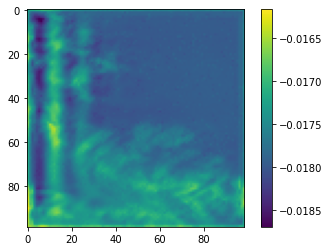

In [17]:
from read import read_wrf
from atmosphere import Nh2L
import matplotlib.pyplot as plt


def main():
    path = '/home/sakura/Lys/sar/data/wrf/wrfout_d01_2013-05-12_22:17:00'
    a, h, _ = read_wrf(path)
    k1, Rd, Rw = 77.6, 287.05, 461.495
    dL1 = 1e-6*(k1*Rd*a.p[-1]/9.81)
    L1 = 1e-6*(k1*Rd*a.p[0]/9.81) - dL1
    N2 = k1*Rd*((a.p - a.vapor_pressure)/Rd + a.vapor_pressure/Rw)/a.ta
    L2 = Nh2L(N2, h)
    plt.imshow(L1-L2)
    plt.colorbar()
    plt.show()


main()

还可以对比一下，WRF数据分辨率是$1km$，距离$1km$的两个点延迟差异会有多大。结果显示$1km$约$10cm$，$2km$约$15cm$。

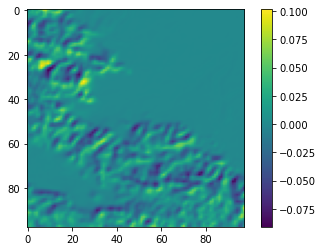

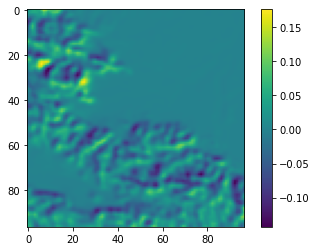

In [7]:
from atmosphere import get_hydro_wet_L
from read import read_wrf
import matplotlib.pyplot as plt


def main(d):
    atmos, h, _ = read_wrf(
        '/home/sakura/Lys/sar/data/wrf/wrfout_d01_2013-05-12_22:17:00')

    L1, L2 = get_hydro_wet_L(atmos, h)
    L = L1 + L2
    plt.imshow(L[d:, d:] - L[:-d, :-d])
    plt.colorbar()
    plt.show()

main(1)
main(2)

## 穿刺点

WRF运行结果是按经纬度划分的，可是经纬度-高程划分出来的三维网格不是立方体，如果将其视作立方体，和信号传播路径计算交点，则可能导致误差。但是，经过比较，发现这种误差是可以接受的。

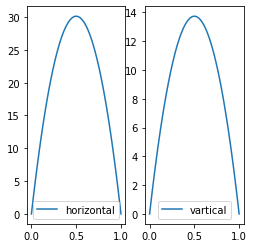

In [6]:
from atmosphere import get_highest
from trans import wgs2ecs, ecs2wgs
import numpy as np
import matplotlib.pyplot as plt


def sp_tp4test():
    tp = wgs2ecs(116.227795125, 40.26829301111111, 99.0687)
    sp = np.array((-2808229.93974116, 4528172.65217887, 4356887.8579095))
    return sp, tp


def diff(r):  # r是矢量
    r = r.reshape((-1, 1))
    sp, tp = sp_tp4test()
    hp = get_highest(sp, tp, height=25e3)
    ltp, lhp = ecs2wgs(tp[0], tp[1], tp[2]), ecs2wgs(hp[0], hp[1], hp[2])

    pseudo_lp = np.multiply(ltp, r)+np.multiply(lhp, 1-r)
    pseudo_p = wgs2ecs(pseudo_lp[:, 0], pseudo_lp[:, 1], pseudo_lp[:, 2]).T
    true_p = np.multiply(tp, r)+np.multiply(hp, 1-r)
    true_lp = ecs2wgs(true_p[:, 0], true_p[:, 1], true_p[:, 2]).T
    dis = np.linalg.norm(pseudo_p - true_p, axis=1)
    dis_h = (pseudo_lp - true_lp)[:, 2]
    dis_plane = np.sqrt(dis**2 - dis_h**2)
    return dis_plane, dis_h


def main():
    x = np.linspace(0, 1, 100)
    y = diff(x)
    for i in range(len(y)):
        plt.subplot(1, len(y)+1, i+1)
        plt.plot(x, y[i], label=["horizontal", "vartical"][i])
        plt.legend()
    plt.show()


main()

取信号传播路径上高程约$25km$的一个点作为最高点，将地面点至“最高点”间的部分经纬度线性化。如图所示，直接通过经纬度计算的点，与通过空间直角坐标计算出的真实值，差异最大的地方在中点，水平方向上偏移了约$30m$，高程高了约$14m$。WRF运行结果的水平分辨率为$1000m$，误差约为$\frac{1}{30}$；高程上的影响也不大。如果一定要纠正这部分误差，可以利用这个方法进行一定的补偿。

`read.py`文件中给出的`Grid`命名元组给出了WRF结果的水平分布，高程分布在另一个参数`h`中。将穿刺点绘制出来，就是这种效果：

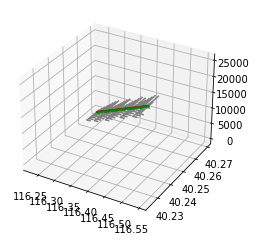

In [8]:
from trans import ecs2wgs, wgs2ecs,  ecs2wgs
from atmosphere import get_highest, get_pierces
from read import read_wrf
import matplotlib.pyplot as plt
import numpy as np


def sp_tp4test():
    tp = wgs2ecs(116.227795125, 40.26829301111111, 99.0687)
    sp = np.array((-2808229.93974116, 4528172.65217887, 4356887.8579095))
    return sp, tp


def h2ll(lhp, ltp, h):
    return (h-ltp[2])/(lhp[2]-ltp[2])*(lhp-ltp)+ltp


def main():
    _, _, grid = read_wrf(
        '/home/sakura/Lys/sar/data/wrf/wrfout_d01_2013-05-12_22:17:00')
    sp, tp = sp_tp4test()
    hp = get_highest(sp, tp)
    lhp, ltp = ecs2wgs(hp[0], hp[1], hp[2]), ecs2wgs(tp[0], tp[1], tp[2])
    res = get_pierces(grid, lhp, ltp)
    dlon = grid.dx if res[-1][1] > res[0][1] else 0
    dlat = grid.dy if res[-1][2] > res[0][2] else 0
    ax = plt.axes(projection='3d')
    last_p = ltp
    for i in res:
        next_p = h2ll(lhp, ltp, i[0])
        lon = grid.lon + grid.dx * i[1] + dlon
        lat = grid.lat + grid.dy * i[2] + dlat
        ax.plot((lon, lon), (lat, lat+grid.dy), (i[0], i[0]), 'gray')
        ax.plot((lon, lon+grid.dx), (lat, lat), (i[0], i[0]), 'gray')
        ax.plot((last_p[0], next_p[0]), (last_p[1], next_p[1]),
                (last_p[2], next_p[2]), 'red')
        ax.scatter3D((next_p[0],), (next_p[1],), (next_p[2],), c='green', s=2)
        last_p = next_p
    plt.show()


main()

将穿刺点转换为延迟的思路比较复杂。由于整个过程中天顶角变化很小（见`test_atmosphere.py::test_get_delay`），所以先计算$\sum N_i\Delta h_i$，最后再统一除以天顶角余弦。

信号从$h=h_{start}$（地面点高程）出发，遍历每一个穿刺点。设穿刺点总共$k$个，那么循环次数为$k+1$。

设循环到第$i$次时，该次循环的起始高程为$h$，已经计算出的延迟为$s$，接下来的穿刺点高程为$h_i$，当前网格经度索引为$a_i$，纬度索引为$b_i$，分层高度为$hs[:,b_i,a_i]$，折射率为$N[:,b_i,a_i]$，那么：

1. 如果$h_i<hs[0,b_i,a_i]$，说明直到下一次穿刺，都不会进入有$N$的范围。令$h=h_i$，结束本次循环；
2. 如果$h<hs[0,b_i,a_i]$，将无效段删去，直接令$h=hs[0,b_i,a_i]$；
3. 找到高于$h$的第1层，即第$j$层，此时$hs[j-1,b_i,a_i]\le h<hs[j,b_i,a_i]$；将$s$减去$N[j-1,b_i,a_i]*(h-hs[j-1,b_i,a_i])$的值，仿佛本次循环的起点变成了$hs[j-1,b_i,a_i]$。这样能够统一之后增加$s$的语句；
4. 找到高于$h_i$的第1层，即第$m$层，此时$hs[m-1,b_i,a_i]\le h_i<hs[m,b_i,a_i]$；令$s=s+\sum_{c=j-1}^{m-1}N[c,b_i,a_i]*(hs[c+1,b_i,a_i]-hs[c,b_i,a_i])$；
5. 收尾工作。如果已经是$hs$的最后一层了，直接结束；否则令$s=s+N[m,b_i,a_i]*(h_i-hs[m,b_i,a_i]$。下次穿透之前的$s$加和完成，起始高度设为$h=h_i$，进入下次循环。

最后的总延迟便是$\frac{s}{10^6\cos\theta}$，$\theta$为天顶角。

## 使用方法

SAR处理流程忽略了大气延迟，所以会把远的东西当成近的。极端一点，假设大气延迟无穷大，那么近在咫尺的目标会被当作无穷远处的目标。因此延迟要与斜距相加，才能更接近真实斜距。

# 间接定位